In [6]:
import pybullet_envs
import numpy as np
import torch
import torch.nn as nn
import os
import pickle
import xarray as xr
import matplotlib.pyplot as plt
import copy
import pybullet_envs
import panda_gym

from seagul.rl.ars.ars_zoo import ARSZooAgent
from seagul.mesh import mdim_div_stable, mesh_dim, mesh_find_target_d
from seagul.rollouts import do_rollout_stable
from seagul.rollouts import load_zoo_agent


torch.set_default_dtype(torch.float32)


%matplotlib inline
%load_ext autoreload
%autoreload 2

#env_name = 'HalfCheetahBulletEnv-v0'
env_name = 'PandaReach-v1'
algo = 'tqc'

env, model = load_zoo_agent(env_name, algo)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading running average
with params: {'norm_obs': True, 'norm_reward': True}


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
odict,a,r,i = do_rollout_stable(env, model);
'achieved_goal'

#plt.plot(o);

1.1765057632828895
7.994432511283337
1.6645905376314194


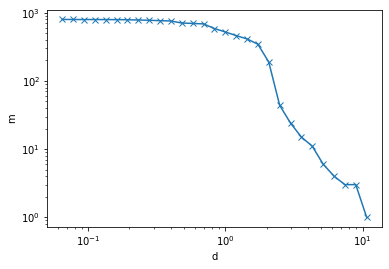

In [14]:
mdim, cdim, m,d = mesh_dim(o[200:], upper_size_ratio=1.0, lower_size_ratio=0.0)
dcrit = mesh_find_target_d(o)

plt.loglog(d,m,'x-')
plt.xlabel('d')
plt.ylabel('m')

print(mdim)
print(cdim)
print(dcrit)

In [3]:
new_agent = ARSZooAgent(env_name, algo, seed=0, n_workers=8, n_delta=64, postprocessor=mdim_div_stable, step_schedule=[0.05, 0.005],  exp_schedule=[0.05, 0.005])

/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env, old_model = load_zoo_agent(env_name, algo)

In [18]:
new_agent.learn(50);
plt.plot(new_agent.raw_rew_hist)

NameError: name 'new_agent' is not defined

In [25]:
model_list = [old_model, new_agent.model]
num_runs = 10

for model in model_list:
    mdims = xr.DataArray(np.zeros((num_runs)))
    rews =  xr.DataArray(np.zeros((num_runs)))

    for j in range(num_runs):
        o,a,r,l = do_rollout_stable(env, model)
        o_norm = env.normalize_obs(o).squeeze()
        o_norm  = o_norm[200:]
        rews[j] = np.sum(r)
        try:
            mdims[j], _, _, _ = mesh_dim(o_norm)
        except:
            mdims[j] = np.nan
    print("mesh dimension")
    print(mdims.data)
    mean = mdims.mean().item()
    std = mdims.std().item()
    print(f"mean: {mean}, std: {std}")

    print("rewards")
    print(rews.data)
    mean = rews.mean().item()
    std = rews.std().item()
    print(f"mean: {mean}, std: {std}")
    print();print()

mesh dimension
[1.65165222 1.50077426 1.47188814 1.43729194 1.4891903  1.51134688
 1.55907226 1.51392266 1.69615533 1.54201792]
mean: 1.537331191504856, std: 0.07612935573121957
rewards
[27.29775238 26.79888535 26.62466812 26.59468842 26.71964455 27.29981232
 27.79039383 27.31723595 27.36193085 27.00781059]
mean: 27.081282234191896, std: 0.37324116445731953


mesh dimension
[1.04105945 1.12599638 1.17756477 1.1979042  1.0433496  1.21110457
 1.03676292 1.09788625 1.22385127 1.1741975 ]
mean: 1.132967691385411, std: 0.07020251916917747
rewards
[22.59495735 23.33088684 23.11067581 23.89262772 21.7189064  23.01237869
 22.86103821 22.09728622 23.60745621 22.56051445]
mean: 22.878672790527343, std: 0.6303239861898635




In [2]:
from ray import tune

def training_function(config):
    import pybullet_envs

    train, env_name, algo = config["train"], config["env_name"], config["algo"]
    env, model = load_zoo_agent(env_name, algo)
    
    if train:
        new_agent = ARSZooAgent(env_name, algo, n_workers=24, n_delta=64, postprocessor=mdim_div_stable, step_schedule=[0.05, 0.005],  exp_schedule=[0.05, 0.005])
        new_agent.learn(100) 
    
    o,a,r,l = do_rollout_stable(env, model)
    o_norm = env.normalize_obs(o).squeeze()
    o_norm  = o_norm[200:]
    rew = np.sum(r)
    
    try:
        mdim, _, _, _ = mesh_dim(o_norm)
    except:
        mdim = np.nan

    tune.report(mdim=mdim, reward=rew)


analysis = tune.run(
    training_function,
    config={
        "train" : tune.grid_search([False, True]),
        "env_name": tune.grid_search(["Walker2DBulletEnv-v0","HalfCheetahBulletEnv-v0","HopperBulletEnv-v0"]),
        "algo": tune.grid_search(['ppo', 'a2c'])
    })

print("Best config: ", analysis.get_best_config(
    metric="mdim", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2021-08-29 02:20:20,584	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-29 02:20:22,149	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-29 02:20:22,174	WARNING tune.py:494 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc,algo,env_name,train
training_function_55f9f_00000,RUNNING,,ppo,Walker2DBulletEnv-v0,False
training_function_55f9f_00001,PENDING,,a2c,Walker2DBulletEnv-v0,False
training_function_55f9f_00002,PENDING,,ppo,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00003,PENDING,,a2c,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00004,PENDING,,ppo,HopperBulletEnv-v0,False
training_function_55f9f_00005,PENDING,,a2c,HopperBulletEnv-v0,False
training_function_55f9f_00006,PENDING,,ppo,Walker2DBulletEnv-v0,True
training_function_55f9f_00007,PENDING,,a2c,Walker2DBulletEnv-v0,True
training_function_55f9f_00008,PENDING,,ppo,HalfCheetahBulletEnv-v0,True
training_function_55f9f_00009,PENDING,,a2c,HalfCheetahBulletEnv-v0,True


(pid=13558) 2021-08-29 02:20:22,693	ERROR function_runner.py:254 -- Runner Thread raised error.
(pid=13558) Traceback (most recent call last):
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ray/tune/function_runner.py", line 248, in run
(pid=13558)     self._entrypoint()
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ray/tune/function_runner.py", line 316, in entrypoint
(pid=13558)     self._status_reporter.get_checkpoint())
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/ray/tune/function_runner.py", line 580, in _trainable_func
(pid=13558)     output = fn()
(pid=13558)   File "<ipython-input-2-761a5f48f0d3>", line 7, in training_function
(pid=13558) NameError: name 'load_zoo_agent' is not defined
(pid=13558) Exception in thread Thread-2:
(pid=13558) Traceback (most recent call last):
(pid=13558)   File "/home/sgillen/anaconda3/envs/baselines/lib/python3.6/threading.p

Result for training_function_55f9f_00000:
  {}
  
Result for training_function_55f9f_00008:
  {}
  
Result for training_function_55f9f_00004:
  {}
  
Result for training_function_55f9f_00006:
  {}
  
Result for training_function_55f9f_00002:
  {}
  
Result for training_function_55f9f_00005:
  {}
  
Result for training_function_55f9f_00007:
  {}
  
Result for training_function_55f9f_00001:
  {}
  
Result for training_function_55f9f_00010:
  {}
  
Result for training_function_55f9f_00011:
  {}
  
Result for training_function_55f9f_00003:
  {}
  
Result for training_function_55f9f_00009:
  {}
  


Trial name,status,loc,algo,env_name,train
training_function_55f9f_00000,ERROR,,ppo,Walker2DBulletEnv-v0,False
training_function_55f9f_00001,ERROR,,a2c,Walker2DBulletEnv-v0,False
training_function_55f9f_00002,ERROR,,ppo,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00003,ERROR,,a2c,HalfCheetahBulletEnv-v0,False
training_function_55f9f_00004,ERROR,,ppo,HopperBulletEnv-v0,False
training_function_55f9f_00005,ERROR,,a2c,HopperBulletEnv-v0,False
training_function_55f9f_00006,ERROR,,ppo,Walker2DBulletEnv-v0,True
training_function_55f9f_00007,ERROR,,a2c,Walker2DBulletEnv-v0,True
training_function_55f9f_00008,ERROR,,ppo,HalfCheetahBulletEnv-v0,True
training_function_55f9f_00009,ERROR,,a2c,HalfCheetahBulletEnv-v0,True


TuneError: ('Trials did not complete', [training_function_55f9f_00000, training_function_55f9f_00001, training_function_55f9f_00002, training_function_55f9f_00003, training_function_55f9f_00004, training_function_55f9f_00005, training_function_55f9f_00006, training_function_55f9f_00007, training_function_55f9f_00008, training_function_55f9f_00009, training_function_55f9f_00010, training_function_55f9f_00011])

In [14]:
import pandas as pd

rd = analysis.results_df.to_csv('test.csv')

'trial_id,mdim,reward,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.train,config.env_name,config.algo\n5f944_00000,1.662833423343824,33.140342712402344,1.1313729286193848,True,,,1,efd44a352c0e4c329aa167aeb426124a,2021-08-29_01-52-02,1630227122,1.1313729286193848,3989,sguc2,128.111.57.96,1.1313729286193848,0,1,"0_algo=ppo,env_name=Walker2DBulletEnv-v0,train=False",False,Walker2DBulletEnv-v0,ppo\n5f944_00001,,3.2583043575286865,0.13784122467041016,True,,,1,f626496cbc8844ec83297e7b39a95d1b,2021-08-29_01-52-01,1630227121,0.13784122467041016,3986,sguc2,128.111.57.96,0.13784122467041016,0,1,"1_algo=a2c,env_name=Walker2DBulletEnv-v0,train=False",False,Walker2DBulletEnv-v0,a2c\n5f944_00002,1.651652224696957,27.297752380371094,1.145392894744873,True,,,1,c68871ecf92c4a8d926fef7de6a7d408,2021-08-29_01-52-02,1630227122,1.

NameError: name 'df' is not defined